https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

## One-Step univariate time series forecast


In [1]:
# univariate data preparation
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import pandas as pd
import tensorflow as tf
import myLibrary as mL
from sklearn.metrics import mean_squared_error, mean_absolute_error

import netCDF4 as nc
import matplotlib.pyplot as plt

---
# Parameters:

In [2]:
STATIONS = ["42036"]    # 33.61% NaN values -> Best value for GOM and 2022
YEARS = ["2022"]
NAN_THRESHOLD = 1
FEATURES = ["WTMP"]
ERA5=True

# when data is converted to stationary data, the observed values are replaced by the difference between value(t) and value(t-STATIONARY_SHIFT)
STATIONARY_SHIFT = 1
lag=1
n_test_hours = 7*24

----
# Load data:

In [3]:
data = mL.get_data(
    stations=STATIONS,
    years=YEARS,
    nan_threshold=NAN_THRESHOLD,
    features=FEATURES,
    #features=None,
    era5=ERA5
    )

data

Started with  2022 . Previous year took:   0.0004940032958984375 seconds
from disc
Finished downloading - now merging it together!
Started with  2022 . Previous year took:   9.5367431640625e-07 seconds
Finished downloading - now merging it together!


,WTMP_42036,WTMP_42036_ERA5
timestamp,,
2022-01-01 00:00:00,23.0,22.942808
2022-01-01 01:00:00,23.0,22.942808
2022-01-01 02:00:00,23.0,22.942808
2022-01-01 03:00:00,23.0,22.942808
2022-01-01 04:00:00,23.0,22.942808
...,...,...
2022-12-31 19:00:00,22.0,21.524296
2022-12-31 20:00:00,22.0,21.524296
2022-12-31 21:00:00,22.1,21.524296


<AxesSubplot:xlabel='timestamp'>

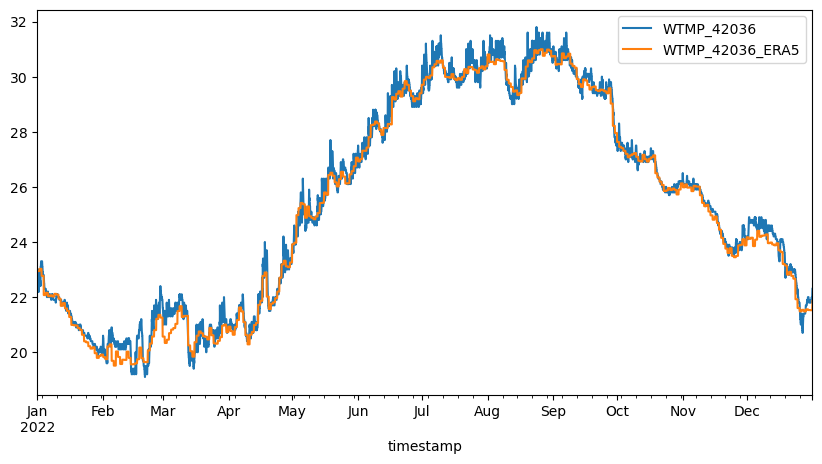

In [4]:
data.plot( figsize=(10, 5))

-----
# Data Preperation:

## 1. Make data stationary

In [49]:
data_stationary = mL.data_to_stationary(data, n = STATIONARY_SHIFT)
data_stationary.head()

,WTMP_42036,WTMP_42036_ERA5
timestamp,,
2022-01-01 01:00:00,0.0,0.0
2022-01-01 02:00:00,0.0,0.0
2022-01-01 03:00:00,0.0,0.0
2022-01-01 04:00:00,0.0,0.0
2022-01-01 05:00:00,0.0,0.0


## 2. Transform to supervised problem

In [50]:
data_supervised = mL.data_to_supervised(data_stationary)
data_supervised.head()

,WTMP_42036(t-1),WTMP_42036_ERA5(t-1),WTMP_42036(t),WTMP_42036_ERA5(t)
timestamp,,,,
2022-01-01 02:00:00,0.0,0.0,0.0,0.0
2022-01-01 03:00:00,0.0,0.0,0.0,0.0
2022-01-01 04:00:00,0.0,0.0,0.0,0.0
2022-01-01 05:00:00,0.0,0.0,0.0,0.0
2022-01-01 06:00:00,0.0,0.0,-0.1,0.0


## train test split

In [8]:
train_X, train_y, test_X, test_y = mL.train_test_split(data_supervised, n_test_hours)
print("Shapes: ", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Shapes:  (8590, 1, 2) (8590, 2) (168, 1, 2) (168, 2)


## Normalize the data

In [51]:
# Scale the data
train_X_scaled, train_y_scaled, test_X_scaled, test_y_scaled, scaler = mL.scale_data(train_X,
                                                                                     train_y,
                                                                                     test_X,
                                                                                     test_y)

----
## LSTM model (no PINN)

In [21]:
# fit an LSTM network to training data
def fit_lstm(train_X, train_y):

    #design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(train_X.shape[2])) # Predict all features!
    model.compile(loss='mean_squared_error', optimizer='adam')   #SGD instead of adam ... SGD is a more simple optimizer which can help avoiding overfitting

    # fit network
    model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=0, shuffle=False)

    return model

In [22]:
lstm_model = fit_lstm(train_X_scaled, train_y_scaled)
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10600     
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
Total params: 10,702
Trainable params: 10,702
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Forecast the entire training dataset to build up state for forecasting
def build_up_state(model):
    #Reset state
    model.reset_states()
    # forecast the entire training dataset to build up state for forecasting
    model.predict(train_X_scaled, batch_size=1)

# One-Shot Forecasting

In [27]:
build_up_state(lstm_model)

8590/8590 [==============================] - 3s 334us/step


In [28]:
output_cols = data_supervised.filter(regex='\(t[\+]*\)').columns.tolist()
prediction_1 = pd.DataFrame(test_y_scaled, columns=output_cols)

yhat = lstm_model.predict(test_X_scaled)
yhat_df = pd.DataFrame(yhat, columns=[name + "_pred" for name in output_cols])

prediction_1 = pd.concat([prediction_1, yhat_df], axis=1)
prediction_1

6/6 [==============================] - 0s 649us/step


,WTMP_42036(t),WTMP_42036_ERA5(t),WTMP_42036(t)_pred,WTMP_42036_ERA5(t)_pred
0,0.04,0.034320,0.039584,0.032651
1,0.04,0.034320,0.039584,0.032651
2,0.04,0.034320,0.039584,0.032651
3,0.04,0.034320,0.039584,0.032651
4,-0.04,0.034320,0.039584,0.032651
...,...,...,...,...
163,0.04,0.034320,0.038995,0.034820
164,0.04,-0.007946,0.039584,0.032651
165,-0.04,0.034320,0.037959,0.032854
166,0.12,0.034320,0.035092,0.031301


<AxesSubplot:>

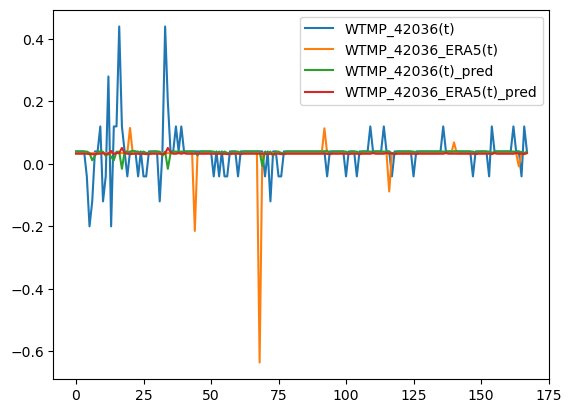

In [29]:
prediction_1.plot(kind='line')

In [30]:
not_scaled = pd.DataFrame(test_y, columns=output_cols)
yhat = mL.invert_scaling(yhat, scaler)
yhat = pd.DataFrame(yhat, columns=[name + "_pred" for name in output_cols])

not_scaled = pd.concat([not_scaled, yhat], axis=1)
not_scaled

,WTMP_42036(t),WTMP_42036_ERA5(t),WTMP_42036(t)_pred,WTMP_42036_ERA5(t)_pred
0,0.0,0.000000,-0.000520,-0.001729
1,0.0,0.000000,-0.000520,-0.001729
2,0.0,0.000000,-0.000520,-0.001729
3,0.0,0.000000,-0.000520,-0.001729
4,-0.1,0.000000,-0.000520,-0.001729
...,...,...,...,...
163,0.0,0.000000,-0.001257,0.000519
164,0.0,-0.043797,-0.000520,-0.001729
165,-0.1,0.000000,-0.002551,-0.001519
166,0.1,0.000000,-0.006135,-0.003128


<AxesSubplot:>

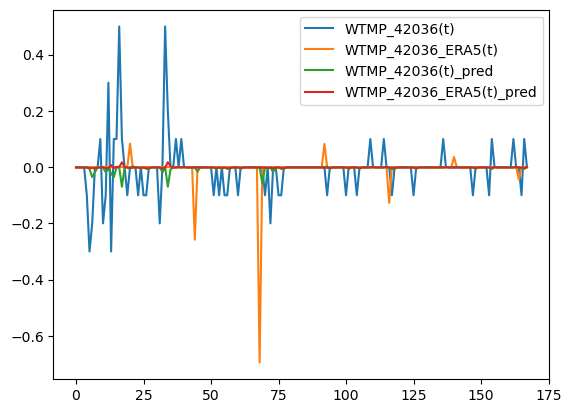

In [31]:
not_scaled.plot(kind='line')

In [16]:
# report performance
# mae = mean_absolute_error(prediction_1["WTMP_NDBC(t)"], prediction_1["WTMP_NDBC(t)_pred"])
# mse = mean_squared_error(prediction_1["WTMP_NDBC(t)"], prediction_1["WTMP_NDBC(t)_pred"])
# print('MAE: ', mae)
# print('MSE: ', mse)

KeyError: 'WTMP_NDBC(t)'

# 2-Week forecast

In [32]:
build_up_state(lstm_model)

8590/8590 [==============================] - 3s 331us/step


In [33]:
# make a one-step forecast
# This function helps with reshaping.
def single_forecast(model, x):
    x = x.reshape(1, 1, len(x[0]))
    yhat = model.predict(x, verbose=0)
    return yhat

In [34]:
prediction_2 = pd.DataFrame(test_y, columns=output_cols)
for col in output_cols:
    prediction_2[f"{col}_pred"] = 0
prediction_2

,WTMP_42036(t),WTMP_42036_ERA5(t),WTMP_42036(t)_pred,WTMP_42036_ERA5(t)_pred
0,0.0,0.000000,0,0
1,0.0,0.000000,0,0
2,0.0,0.000000,0,0
3,0.0,0.000000,0,0
4,-0.1,0.000000,0,0
...,...,...,...,...
163,0.0,0.000000,0,0
164,0.0,-0.043797,0,0
165,-0.1,0.000000,0,0
166,0.1,0.000000,0,0


In [35]:
prev_obs = test_X[0]
for i, row in prediction_2.iterrows():
    yhat = single_forecast(lstm_model, prev_obs)

    #Mapping of array index and df column name
    for j, element in enumerate(output_cols):
        prediction_2.at[i, f"{element}_pred"] =yhat[0,j]

prediction_2

,WTMP_42036(t),WTMP_42036_ERA5(t),WTMP_42036(t)_pred,WTMP_42036_ERA5(t)_pred
0,0.0,0.000000,0.036196,0.03207
1,0.0,0.000000,0.036196,0.03207
2,0.0,0.000000,0.036196,0.03207
3,0.0,0.000000,0.036196,0.03207
4,-0.1,0.000000,0.036196,0.03207
...,...,...,...,...
163,0.0,0.000000,0.036196,0.03207
164,0.0,-0.043797,0.036196,0.03207
165,-0.1,0.000000,0.036196,0.03207
166,0.1,0.000000,0.036196,0.03207


<AxesSubplot:>

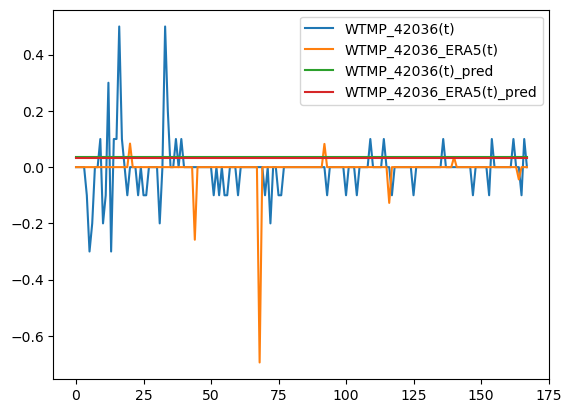

In [36]:
prediction_2.plot(kind='line')

In [37]:
# report performance
mae = mean_absolute_error(prediction_2["WTMP_NDBC(t)"], prediction_2["WTMP_NDBC(t)_pred"])
mse = mean_squared_error(prediction_2["WTMP_NDBC(t)"], prediction_2["WTMP_NDBC(t)_pred"])
print('MAE: ', mae)
print('MSE: ', mse)

KeyError: 'WTMP_NDBC(t)'

----

# REAL PINN STUFF

In [38]:
ALPHA = 1

In [39]:
from keras import backend as K

def custom_loss(alpha):
    def loss(y_true, y_pred):
        # Split y_true and y_pred into two features
        y_true_f1, y_true_f2 = tf.split(y_true, num_or_size_splits=2, axis=1)
        y_pred_f1, y_pred_f2 = tf.split(y_pred, num_or_size_splits=2, axis=1)

        # Calculate the mean squared error for each feature
        mse_f1 = K.mean(K.square(y_true_f1 - y_pred_f1), axis=-1)
        mse_f2 = K.mean(K.square(y_true_f2 - y_pred_f2), axis=-1)

        # Calculate the weighted loss
        weighted_loss = alpha * mse_f1 + (1-alpha) * mse_f2

        return weighted_loss

    return loss

In [40]:
def fit_pinn(train_X, train_y):

    #design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(train_X.shape[2])) # Predict all features!

    model.compile(optimizer='adam',
                  loss=custom_loss(alpha=ALPHA),
                  #loss='mean_squared_error',
                  )

    # fit network
    model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=0, shuffle=False)

    return model

In [41]:
pinn_model = fit_pinn(train_X, train_y)
pinn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10600     
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 10,702
Trainable params: 10,702
Non-trainable params: 0
_________________________________________________________________


In [42]:
build_up_state(pinn_model)

8590/8590 [==============================] - 3s 327us/step


In [43]:
output_cols = data_supervised.filter(regex='\(t[\+]*\)').columns.tolist()
prediction_3 = pd.DataFrame(test_y, columns=output_cols)

yhat = pinn_model.predict(test_X)
yhat = pd.DataFrame(yhat, columns=[name + "_pred" for name in output_cols])

prediction_3 = pd.concat([prediction_3, yhat], axis=1)
prediction_3

6/6 [==============================] - 0s 605us/step


,WTMP_42036(t),WTMP_42036_ERA5(t),WTMP_42036(t)_pred,WTMP_42036_ERA5(t)_pred
0,0.0,0.000000,0.000274,0.000270
1,0.0,0.000000,0.000274,0.000270
2,0.0,0.000000,0.000274,0.000270
3,0.0,0.000000,0.000274,0.000270
4,-0.1,0.000000,0.000274,0.000270
...,...,...,...,...
163,0.0,0.000000,-0.000098,-0.000711
164,0.0,-0.043797,0.000274,0.000270
165,-0.1,0.000000,-0.001823,0.000134
166,0.1,0.000000,-0.005880,0.002135


In [52]:
# report performance
mae = mean_absolute_error(prediction_3["WTMP_42036(t)"], prediction_3["WTMP_42036(t)_pred"])
mse = mean_squared_error(prediction_3["WTMP_42036(t)"], prediction_3["WTMP_42036(t)_pred"])
print('MAE: ', mae)
print('MSE: ', mse)

MAE:  0.03957591510150548
MSE:  0.008011446952581614


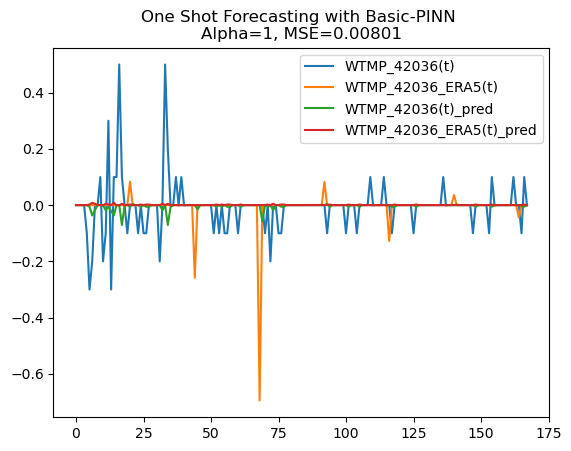

In [53]:
prediction_3.plot(kind='line')
plt.title(f'One Shot Forecasting with Basic-PINN \nAlpha={ALPHA}, MSE={mse.round(5)}')
plt.show()